In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

keys = ['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数','氨氮', '总磷', '总氮']
en_keys = ['WaterTemperature', 'PH' ,'dissolved oxygen', 'Conductivity','Turbidity','PermanganateIndex',
        'AmmoniaNitrogen','TP','TN', 'humidity','room temperature','chlorophyll','Algae density']
# limits = [(5, 30), (5.0, 9), (1, 15), (50, 500), (0, 1500), (0, 15), (0, 0.5), (0, 0.3), (0, 5)]

np.set_printoptions(formatter = {'float': '{:.2e}'.format})


In [ ]:
df = pd.read_excel('./origional_data/泸沽湖邛海鲁班水库水质数据/原始查询/原始查询（礼板湾(王妃岛)-泸沽湖）.xls', 
                   header=2, usecols=keys, index_col=0)
df = df.loc[::-1]
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.replace(to_replace= '--', value = np.nan, inplace=True)
df = df.astype('float64')
df = df.drop(df[df.index <= '2018-08-07'].index)
df = remove_outliers(df, standard_deviation, 25)

df = df.resample('4H', 'index').mean()
df = patch_up(df, 7)
df = smooth(df, 3)

In [ ]:
index_nums = len(df.keys())
print(df.keys())
l, h = 18, 3
fig, axis = plt.subplots(index_nums, 1, figsize=(l, h*index_nums), constrained_layout=True)
for i in range(index_nums):
    name = en_keys[i]
    df.plot(y=df.keys()[i], ax=axis[i])
    axis[i].set_title(name, fontsize=20)
    axis[i].set_xlabel('', fontsize=15)
    axis[i].set_ylabel('', fontsize=15)
    
    axis[i].legend([name], fontsize=15)

In [ ]:
figure, axis = plt.subplots(3, 1, figsize=(30, 10))
name = keys[5]
vals = df[name].values.copy()
print(f'{name}, {len(vals)}')
print(vals)
X = np.linspace(0, 1, len(vals))
axis[0].plot(X, vals)
axis[0].set_title('UnSmooth')
smooth_vals = pd.Series(vals).ewm(span=30).mean()
axis[1].plot(X, smooth_vals)
axis[1].set_title('Smooth')
scaled_vals = (smooth_vals - smooth_vals.min()) / smooth_vals.max()
axis[2].plot(X, scaled_vals)
axis[2].set_title('scaled')


plt.show()

In [2]:
from pathlib import Path
p = Path("./data/")
for csv in p.glob("*.csv"):
    print(csv.stem)

luguhuxin
qionghai
wangfeidao
luban


In [7]:
df = pd.read_csv('./data/qionghai.csv', index_col=0)
maxs, mins = df.loc['max'].values, df.loc['min'].values
df = df.drop(['max', 'min'])
print(maxs)

[3.17e+01 8.88e+00 1.04e+01 3.83e+02 9.78e+00 2.43e+00 5.02e-02 2.20e-02
 5.90e-01]


In [8]:
import torch
from trainer import *

def test(ckpt_path, model, data, lPre=42, lGet=84, step=3):
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()
    
    l, f = data.shape
    data = np.transpose(data)
    pre = np.zeros((l-lGet, f))
    data = torch.from_numpy(data).to(torch.float32)
    data = data[None, ...]
    print(data.shape)
    max_idx = l - step - lGet
    
    i = 0
    while i <= max_idx:
        x = data[:, :, i: i + lGet]
        y = model(x).numpy().squeeze()
        pre[i : i + step] = y[:, :step].transpose()
        i += step
        
    return pre

kwargs = {'features': 9,
        'lPre': 42,
        'lGet' : 84,
        'Tree_levels':2,
        'hidden_size_rate':4,
        'loss':F.l1_loss,
        'lr':9e-3,
         'descaler':None}
    
model = SCIModule(**kwargs)
pre = test('./lightning_logs/7d/checkpoints/last.ckpt', model, df.values, lPre=42, lGet=84, step=3)

torch.Size([1, 9, 9168])


In [9]:
data = df.values
data = data * (maxs - mins) + mins
pre = pre * (maxs - mins) + mins
from datetime import datetime
date = list(df.index)
x = []
for k in date:
    x.append(datetime.strptime(k, '%Y-%m-%d %H:%M:%S'))

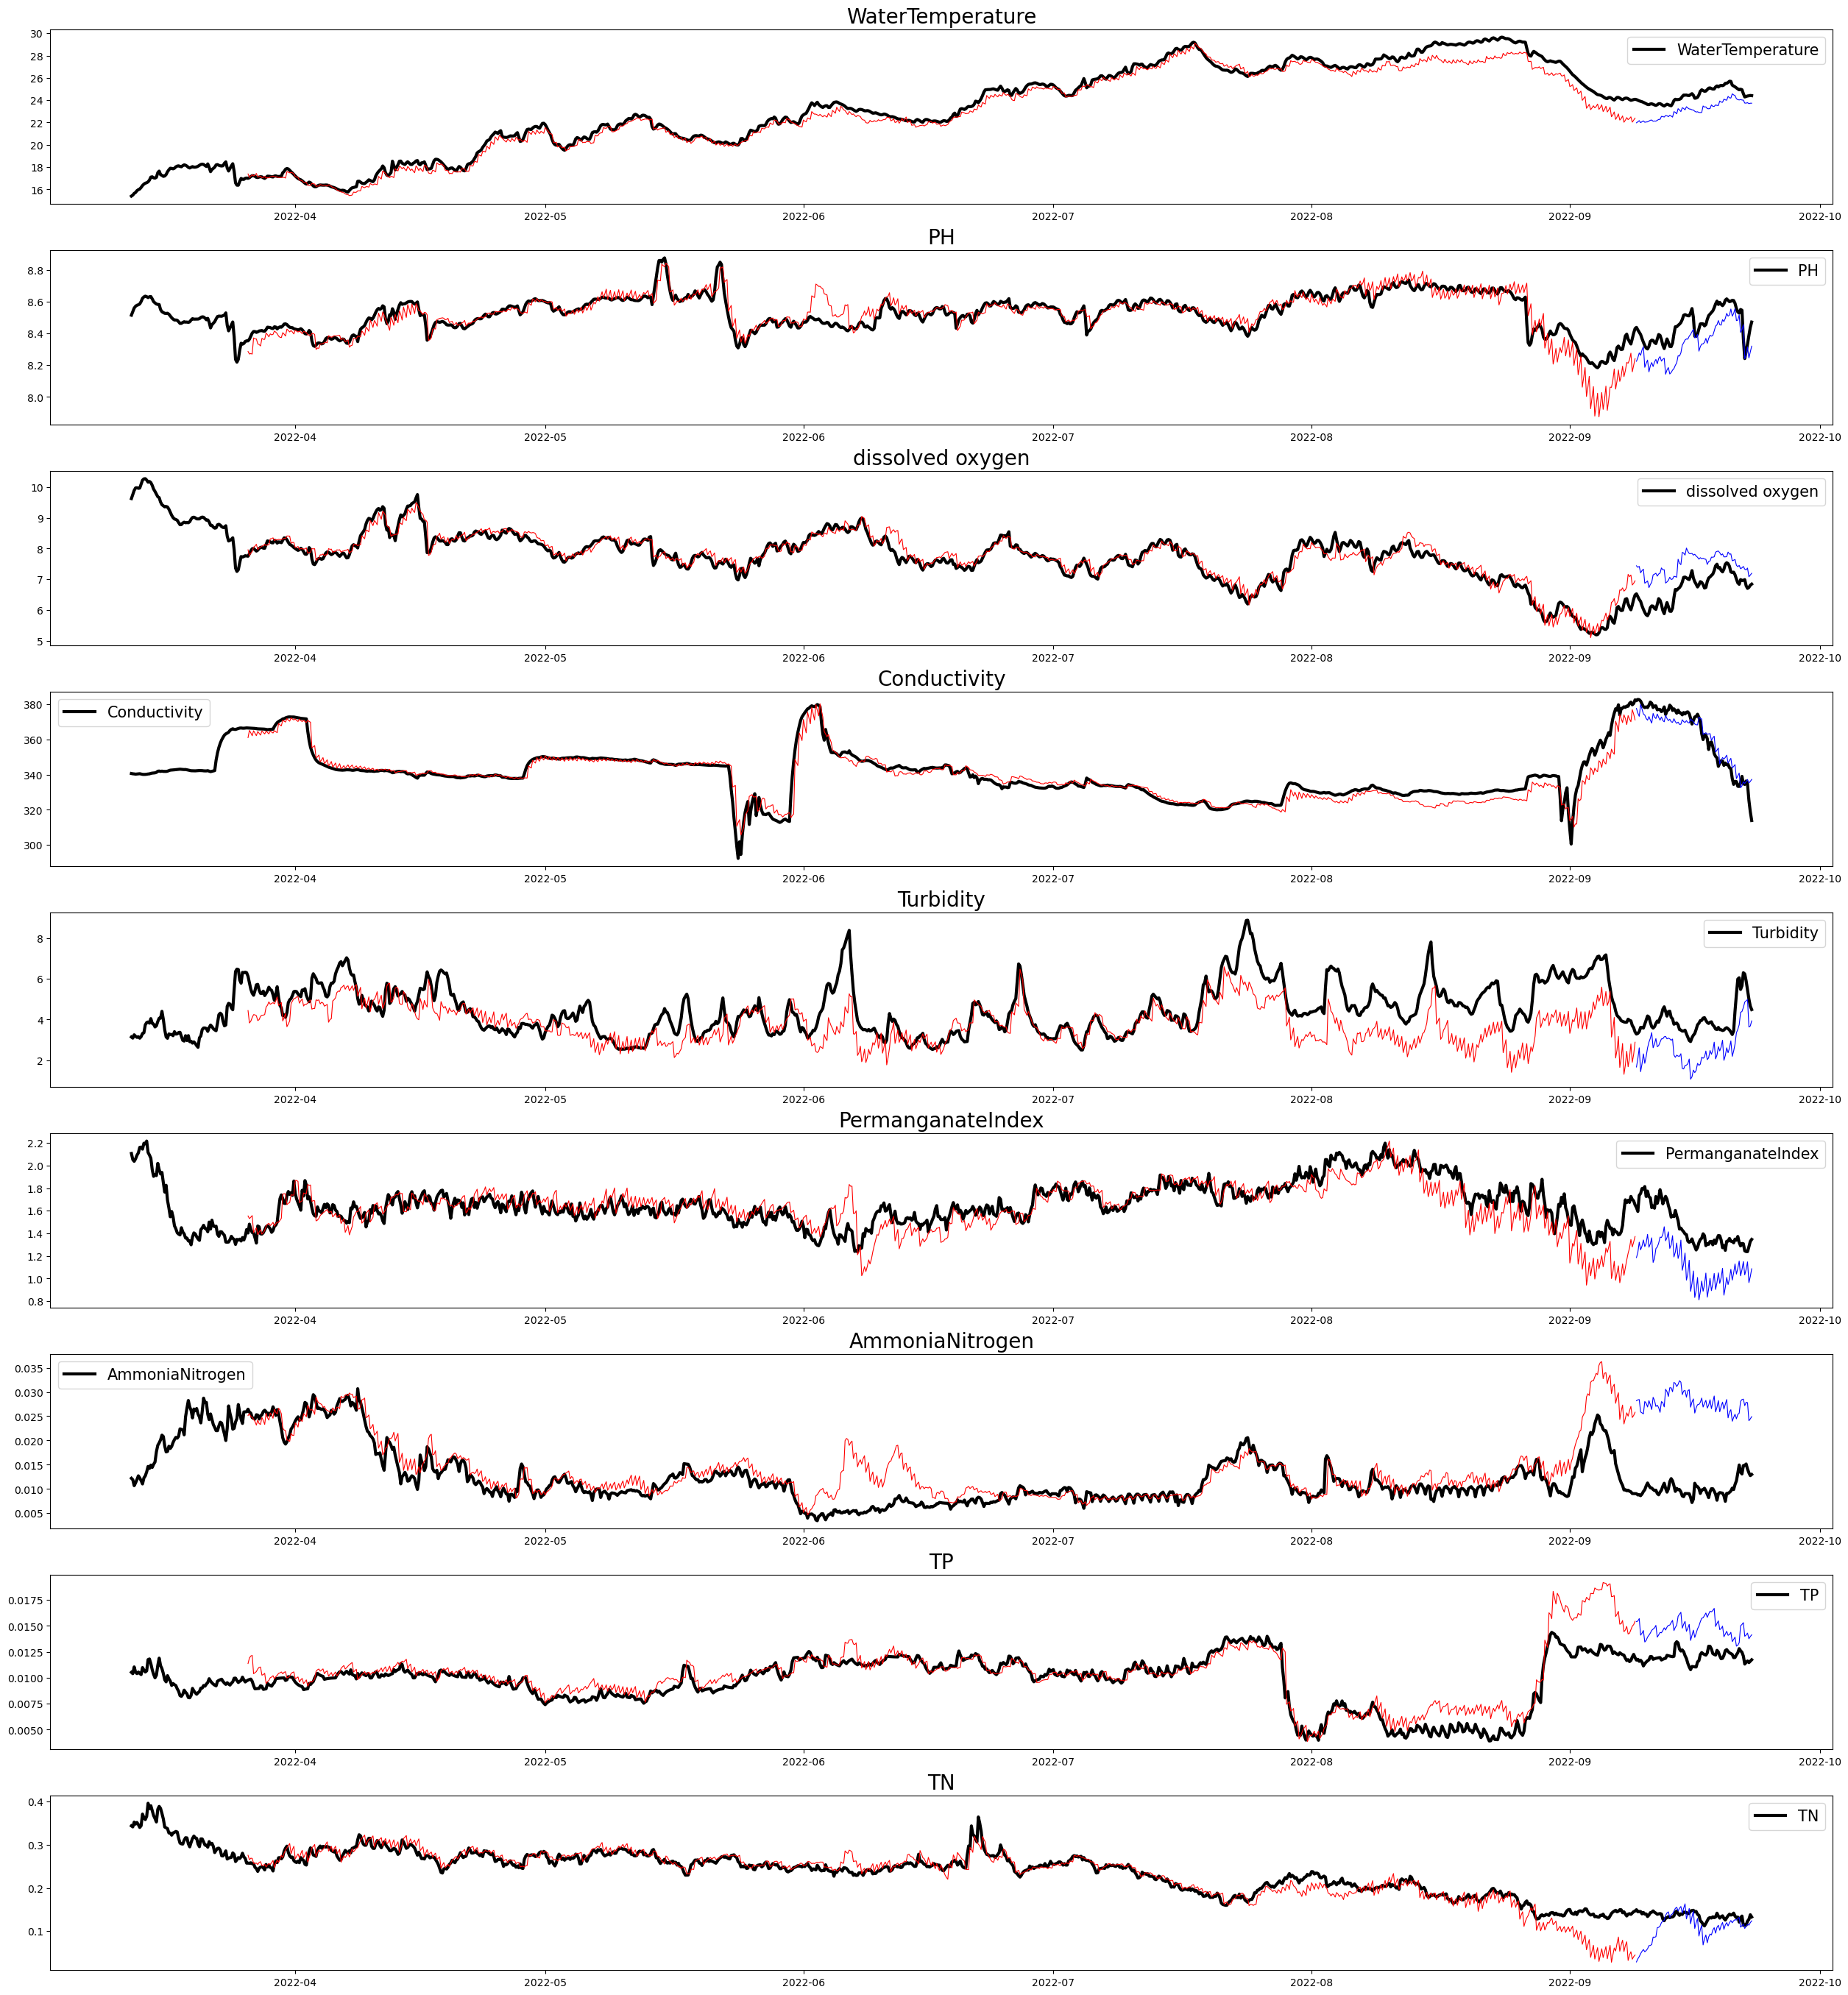

In [10]:
lPre, lGet = 42, 84
features = data.shape[1]
l, h = 25, 3

window = 8000
index = x[window:]
real = data[window:, :]
prediction = pre[window:, :]

def plot(x, data, pre, area=9000, lGet=84):
    fig, axis = plt.subplots(features, 1, figsize=(l, h*features), constrained_layout=True)

    for i in range(features):
        name = en_keys[i]
        axis[i].plot(x[:], data[:, i], '-k', linewidth=3)
        axis[i].plot(x[lGet:area+lGet], pre[:area, i], '-r', linewidth=0.8)
        axis[i].plot(x[area+lGet:], pre[area:, i], '-b', linewidth=0.8)

    #     df.plot(y=k, ax=axis[i], style='-k')
    #     df.plot(y=f'{k}(pre)', ax=axis[i], style='--r')

        axis[i].set_title(name, fontsize=20)
        axis[i].set_xlabel('', fontsize=15)
        axis[i].set_ylabel('', fontsize=15)

        axis[i].legend([name], fontsize=15)
    
plot(index, real, prediction, 9000-window)

In [ ]:
df = df * (maxs - mins) + mins
val = df.values
print(val.shape)